In [32]:
import os
import cv2
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, MaxPooling2D, Flatten,Conv2D,Reshape, Conv1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import LabelEncoder
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras import losses
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import shutil
import sys
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import  preprocess_input
from keras.utils import to_categorical
import os
import cv2 as cv
from sklearn.metrics import roc_auc_score

In [33]:
# Set up the paths to the input directories
train_dir = r"C:\Users\pc\OneDrive\Desktop\CS\semester6\Computer Vision (CS4802)\Project\Face_splittedData\train"
test_dir =  r"C:\Users\pc\OneDrive\Desktop\CS\semester6\Computer Vision (CS4802)\Project\Face_splittedData\test"
# Set up the image dimensions
img_height = 224
img_width = 224

 

# Define a function to preprocess the images
def preprocess_images(data_dir):
    training_data = []
    X = []
    y = []
    
    for class_name in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, class_name)
        if os.path.isdir(class_dir):
            for file_name in os.listdir(class_dir):
                if file_name.endswith('.jpg'):
                    img_path = os.path.join(class_dir, file_name)
                    img = cv2.imread(img_path)
                    img = cv2.resize(img, (img_height, img_width))
                    img= img_to_array(img)
                    img=preprocess_input(img)
                    training_data.append([img,class_name])
                    
    import random
    random.shuffle(training_data)
#     for sample in training_data[:10]:
#          print(sample[1]) 
    
    for features,label in training_data:
        X.append(features)
        y.append(label)
    
                    
    X = np.array(X)
    y = np.array(y)
    
    # Normalize the data using mean and standard deviation and we applied the normalization before the oversamling to prevent data leakage
    scaler = StandardScaler()
    X = scaler.fit_transform(X.reshape(X.shape[0], -1))
    X = X.reshape(-1, img_height, img_width, 3)
    
    # Apply SMOTE to balance the classes(oversambling as our data is imbalanced)
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X.reshape(X.shape[0], -1), y)
    X_resampled = X_resampled.reshape(-1, img_height, img_width, 3)
    
   
    
    
    # Perform label encoding on the target variable (labels)
#     label_encoder = LabelEncoder()
#     y_resampled = label_encoder.fit_transform(y_resampled)
    
    return X_resampled, y_resampled




In [34]:
# Preprocess the training data
train_X, train_y = preprocess_images(train_dir)

# Preprocess the testing data
test_X, test_y = preprocess_images(test_dir)

In [35]:
print("the trainX shape is:",train_X.shape)
print("the testx shape is",test_X.shape)
print("the ytrain shape is:",train_y.shape)
print("the ytest shape is:",test_y.shape)

the trainX shape is: (1346, 224, 224, 3)
the testx shape is (506, 224, 224, 3)
the ytrain shape is: (1346,)
the ytest shape is: (506,)


In [36]:
# Load the VGG16 model without the top classification layer
vgg16_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

In [37]:
#This will set all layers in the VGG16 model to be untrainable so that their weights will not be updated during training.
for layer in vgg16_model.layers:
    layer.trainable = False

In [38]:
#fine tune the way u desire
headModel = vgg16_model.output
headModel = Flatten()(headModel)
headModel = Dense(256, activation='relu')(headModel)
headModel = Dense(128, activation='relu')(headModel)
headModel = Dense(1, activation='sigmoid')(headModel)

In [39]:
model=Model(inputs=vgg16_model.input, outputs=headModel)

In [40]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [41]:
metrics = ['accuracy',
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall')]

In [43]:
model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=metrics)

In [44]:
label_encoder = LabelEncoder()
train_y_encoded = label_encoder.fit_transform(train_y)
test_y_encoded = label_encoder.transform(test_y)

In [45]:
train_y_encoded[:10]



array([0, 1, 1, 0, 0, 0, 0, 1, 0, 0], dtype=int64)

In [46]:
with tf.device('/device:CPU:0'):
    #khalena elepochs w el batches w el optimizer zy b3dena
    history = model.fit(train_X,train_y_encoded,batch_size=64 ,epochs=10,
                            validation_data=(test_X, test_y_encoded))

Epoch 1/10
22/22 [==============================] - 216s 10s/step - loss: 0.3659 - accuracy: 0.9094 - precision: 0.9245 - recall: 0.8915 - val_loss: 0.0554 - val_accuracy: 0.9783 - val_precision: 0.9583 - val_recall: 1.0000
Epoch 2/10
22/22 [==============================] - 162s 7s/step - loss: 0.0236 - accuracy: 0.9918 - precision: 0.9911 - recall: 0.9926 - val_loss: 4.8518e-04 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 3/10
22/22 [==============================] - 165s 8s/step - loss: 0.0039 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - val_loss: 2.6053e-05 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 4/10
22/22 [==============================] - 167s 8s/step - loss: 3.4067e-05 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 4.0335e-05 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 5/10
22/22 [==============================] - 170s 8s/step - loss: 2.5171e-05 - accur

In [47]:
with tf.device('/device:CPU:0'):
    y_pred = model.predict(test_X)

16/16 [==============================] - 51s 3s/step


In [48]:
# Convert the predicted probabilities to class labels
threshold = 0.5

y_pred_classes = np.where(y_pred >= threshold, 1, 0)

conf_mat = confusion_matrix(test_y_encoded, y_pred_classes)

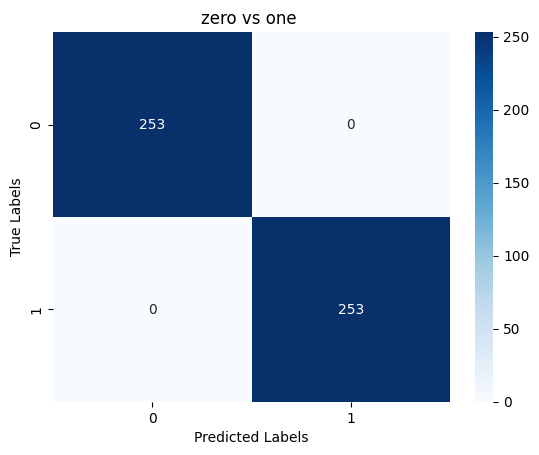

In [49]:
# Compute the confusion matrix
cm = confusion_matrix(test_y_encoded, y_pred_classes)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, cmap="Blues",fmt='g')

# Add labels and title to the plot
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("zero vs one ")

# Show the plot
plt.show()

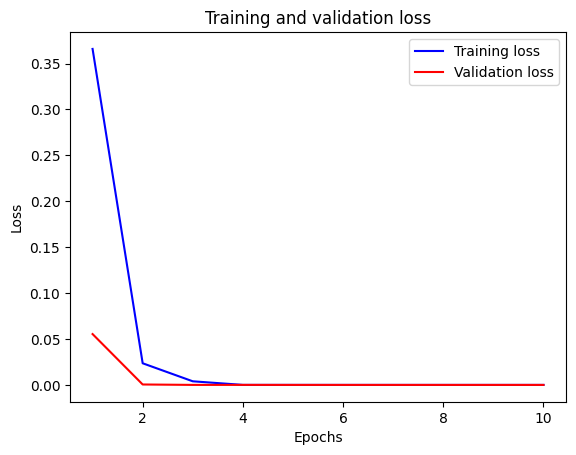

In [50]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'b-', label='Training loss')
plt.plot(epochs, val_loss, 'r-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

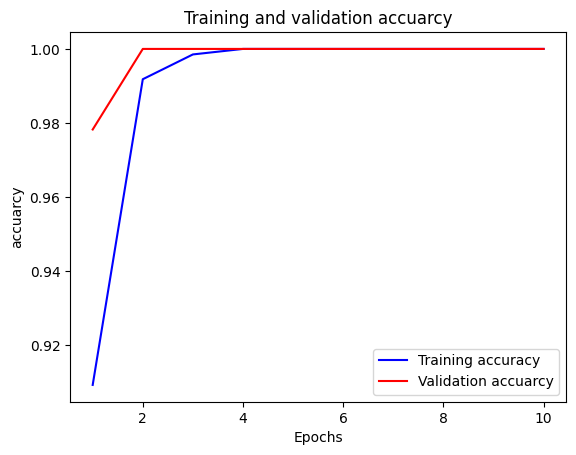

In [51]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(train_accuracy) + 1)

plt.plot(epochs, train_accuracy, 'b-', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation accuarcy')
plt.title('Training and validation accuarcy')
plt.xlabel('Epochs')
plt.ylabel('accuarcy')
plt.legend()

plt.show()

In [52]:
from sklearn.metrics import confusion_matrix, classification_report

# assume y_true and y_pred are the ground truth and predicted labels respectively
# for a multi-class classification problem with classes 0 to n-1
cm = confusion_matrix(test_y_encoded, y_pred_classes)
report = classification_report(test_y_encoded, y_pred_classes)

# recall for each class can be obtained from the classification report
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       253
           1       1.00      1.00      1.00       253

    accuracy                           1.00       506
   macro avg       1.00      1.00      1.00       506
weighted avg       1.00      1.00      1.00       506



In [53]:
# calculate AUC score
auc_score = roc_auc_score(test_y_encoded, y_pred_classes)

# print the AUC score
print("AUC score: {:.2f}".format(auc_score))

AUC score: 1.00
